In [35]:
import numpy as np
import subprocess
import time
import copy
from utils.opt_utils import *
import os
import h5py
import pickle
from qutip import *

In [41]:
wc_A = 4.069814 * (10**9) * 2 * np.pi  # cavity A frequency
wc_B = 6.096062 * (10**9) * 2 * np.pi  # cavity A frequency
wa =  5.325 * (10**9) * 2 * np.pi  # atom frequency
dt_A = np.abs(wc_A - wa) / (2 * np.pi)
dt_B = np.abs(wc_B - wa) / (2 * np.pi)
chi_A = 0.00215 * (10**9) * 2 * np.pi
chi_B = 0.00544 * (10**9) * 2 * np.pi
g_A = np.sqrt(chi_A * dt_A) * 2 * np.pi  # coupling strength w/ cavity A
g_B = np.sqrt(chi_B * dt_B) * 2 * np.pi  # coupling strength w/ cavity B

gamma = 333333.333        # atom dissipation rate
kappa_A = 10000       # cavity A dissipation rate
kappa_B = 10000       # cavity B dissipation rate

temp_q = 0.01        # avg number of thermal bath excitation for qubit
temp_A = 0.04        # avg number of thermal bath excitation for cavity A
temp_B = 0.05        # avg number of thermal bath excitation for cavity B

tlist = np.linspace(0, 0.000003, 501)

In [74]:
# Cost function
def cost_q_e(final_expect, final_dm):
    # print(final_expect[0])
    return(final_expect[0])

def cost_qA_g1(final_expect, final_dm):
    # print(final_dm.full())
    return np.abs(final_dm.full()[1][0])

def cost_qAB_g11(final_expect, final_dm):
    return np.abs(final_dm.full()[7][0])

def cost_qAB_g11_n(final_expect, final_dm):
    noise = (np.random.rand(1)[0] * 0.06) - 0.03
    return np.abs(final_dm.full()[7][0]) + noise

In [78]:
# ========== OPTIONS ========== #
max_segs = 20
time_start = 0.0000000
time_stop = 0.000001
init_amp = 200000
n_steps = 501

num_drives = 3
num_elems = 3
num_cavities = 2
cavity_dims = 8
state_sizes = [2, cavity_dims, cavity_dims]
state_vals = [0, 0, 0]
init_freqs = [wa, wc_A, wc_B]
sim_options = Options()
element_freqs = [wa, wc_A, wc_B]
output_cost_func = cost_qAB_g11_n
elements = "qAB"
range_len = 20
start_split_num = 1
n_seg_jump = 1
verbose = True

save_dir = 'save_data'
hdf5_name = os.path.join(save_dir, time.strftime('g11-n02-%Y%m%d-%H%M%S.h5'))
epochs = 1000
epochs_per_seg = 300
train_batch_size = 20
qubit_amp_scale = 4
cavity_amp_scale = 4
freq_scale = 0.0005
# ========== OPTIONS ========== #

t_step = (time_stop - time_start) / n_steps

qscale = []
cscale = []
for i in range(2):
    qscale.append(init_amp * qubit_amp_scale)
    cscale.append(init_amp * cavity_amp_scale)
    cscale.append(init_amp * cavity_amp_scale)

sm, a_A, a_B, sx, sz = reg_ops(num_cavities + 1, cavity_dims)
drive_freqs = np.array(init_freqs)

gammas = [gamma, kappa_A, kappa_B]
temps = [temp_q, temp_A, temp_B]
c_ops = [] # gen_c_ops(elements, [sm, a_A, a_B, sx, sz], gammas, temps)

# Operators used in Hamiltonian
drive_ops = [sm.dag(), sm, a_A.dag(), a_A, a_B.dag(), a_B]
element_ops = [sz, a_A.dag() * a_A, a_B.dag() * a_B]
H_0 = (chi_A * a_A.dag() * a_A * sz / 2) + (chi_B * a_B.dag() * a_B * sz / 2)
eval_ops = [sm.dag() * sm, a_A.dag() * a_A, a_B.dag() * a_B] # [sm.dag() * sm, a_A.dag() * a_A, a_B.dag() * a_B] # [sm.dag() * sm, a_A.dag() * a_A, a_B.dag() * a_B, tensor(destroy(2) * destroy(2).dag(), destroy(cavity_dims).dag() * destroy(cavity_dims), destroy(cavity_dims).dag() * destroy(cavity_dims))]

t_segs, amp_segs = setup_segs(2 * num_drives, time_start, time_stop, init_amp)
amp_segs[:2, :] = 200000
amp_segs[2:, :] = 200000

# Setup initial state
# init_state = build_psi(state_sizes, state_vals)
init_state = tensor((basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0])), (basis(state_sizes[1], 0) * np.sqrt(1 - state_vals[1])) + (basis(state_sizes[1], 1) * np.sqrt(state_vals[1])), (basis(state_sizes[2], 0) * np.sqrt(1 - state_vals[2])) + (basis(state_sizes[2], 1) * np.sqrt(state_vals[2])))

# Create blank history arrays for storing optimal / past values
time_hist = []
amp_hist = []
freq_hist = []
cost_hist = []

In [79]:
# Split "x" times:
for i in range(start_split_num - 1):
    t_segs, amp_segs = split_segs(t_segs, amp_segs)

In [80]:
# Run vqe, etc
hdf5_start_index = 0
start_segs = 0
for i in range(range_len):

    temp_amp_scale = copy.deepcopy(amp_segs)
    if np.shape(temp_amp_scale)[0] < 2:
        temp_amp_scale[:, :] = np.vectorize(max)(np.abs(amp_segs * qubit_amp_scale), init_amp * np.ones(np.shape(amp_segs)) / qubit_amp_scale)
    else:
        temp_amp_scale[:2, :] = np.vectorize(max)(np.abs(amp_segs[:2] * qubit_amp_scale), init_amp * np.ones(np.shape(amp_segs[:2])) / qubit_amp_scale)
        temp_amp_scale[2:, :] = np.vectorize(max)(np.abs(amp_segs[2:] * cavity_amp_scale), init_amp * np.ones(np.shape(amp_segs[2:])) / cavity_amp_scale)
    temp_freq_scale = list(freq_scale * np.array(drive_freqs))
    
    client_args = [num_drives, num_elems, drive_ops, t_segs, t_step, H_0, init_state, c_ops, eval_ops, sim_options, element_ops, element_freqs, output_cost_func, verbose]
    server_args = [(len(t_segs[0]) - 1) * epochs_per_seg, train_batch_size, amp_segs, drive_freqs, temp_amp_scale, temp_freq_scale, hdf5_name]

    
    # Save args for rl client
    cf_name = "temp_files/client_args.txt"
    with open(cf_name, "wb") as fp:
        pickle.dump(client_args, fp)
    fp.close()
    
    # Save args for rl server
    sf_name = "temp_files/server_args.txt"
    with open(sf_name, "wb") as fp:
        pickle.dump(server_args, fp)
    fp.close()
    

    os.system('cmd /c python ./run_rl_scripts.py')
    
    # Give time for files to be updated etc
    time.sleep(1)
    
    opt_amps = []
    opt_freqs = []
    with h5py.File(hdf5_name, "r") as f:
        opt_res_index = np.argmax(f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()])
        opt_result = f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()][opt_res_index]
        for j in range(2 * num_drives):
            opt_amps.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'pulse_array_{j}'][()][opt_res_index]])
        for j in range(num_drives):
            opt_freqs.append(f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'freq_{j}'][()][opt_res_index])
    
    # updates amplitudes and frequencies with optimized values and reshape
    amp_segs = np.array(opt_amps)
    amp_segs = np.reshape(amp_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))
    
    print(f'================')
    print(f'num segs: {start_split_num + i + start_segs} ')
    print(f'opt_amps: {amp_segs}')
    print(f'opt_freqs: {opt_freqs}')
    print(f'opt_result: {opt_result}')

    # save values to history arrays
    time_hist.append(t_segs)
    amp_hist.append(amp_segs)
    freq_hist.append(drive_freqs)
    cost_hist.append(opt_result)

    for i in range(2 * n_seg_jump):
        qscale.append(init_amp * qubit_amp_scale)
        cscale.append(init_amp * cavity_amp_scale)
        cscale.append(init_amp * cavity_amp_scale)

    # split segments and return to start of loop
    if (i < max_segs - 1):
        for i in range(n_seg_jump):
            t_segs, amp_segs = split_segs(t_segs, amp_segs)

num segs: 1 
opt_amps: [[187123.45 ]
 [110567.695]
 [308150.5  ]
 [266412.3  ]
 [238940.97 ]
 [142389.67 ]]
opt_freqs: [33457957000.0, 25571758000.0, 38302920000.0]
opt_result: [0.01971655]
num segs: 2 
opt_amps: [[263286.88  102439.1  ]
 [  5278.297  17137.828]
 [207254.52  251184.   ]
 [261593.5   462029.12 ]
 [196924.55  210392.27 ]
 [138762.75  168566.58 ]]
opt_freqs: [33455942000.0, 25569888000.0, 38302274000.0]
opt_result: [0.01876541]
num segs: 3 
opt_amps: [[ 166219.81    34690.234   51974.984]
 [  10541.666   13437.568    6968.001]
 [ -12419.516  151862.12  -435421.88 ]
 [ 546782.8    161618.4   1262458.2  ]
 [  26724.64    14322.797  228967.8  ]
 [ 186315.38   645906.25   197006.53 ]]
opt_freqs: [33454232000.0, 25571957000.0, 38300840000.0]
opt_result: [0.01989509]
num segs: 4 
opt_amps: [[ 3.4856325e+05  4.6372879e+04  2.4555348e+04  8.9134984e+04]
 [-8.4681484e+03 -1.3444594e+04  3.1264020e+04  4.8239238e+03]
 [-8.0512534e+03  2.0852500e+03 -1.3674381e+05 -3.9526741e+05]
 [

KeyboardInterrupt: 

In [21]:
for i in range(n_seg_jump):
            t_segs, amp_segs = split_segs(t_segs, amp_segs)

In [ ]:
print(amp_segs)

In [ ]:
print(t_segs)
print(amp_segs)

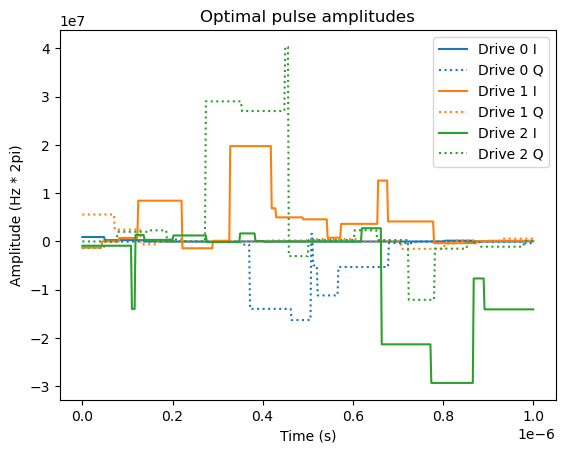

In [10]:
drive_pulse_plot(t_segs, amp_segs)

In [11]:
# Evolution of states over time
print(amp_segs)
x0 = np.append(amp_hist[0].flatten(), opt_freqs[0])
print(f'x0: {x0}')
args = [num_drives, num_elems, drive_ops, t_segs, t_step, H_0, init_state, c_ops, eval_ops, sim_options, element_ops, element_freqs, output_cost_func, verbose]
# args[]
# (num_drives, drive_ops, time_hist[-1], t_step, H_0, init_state, c_ops, eval_ops, sim_options, element_ops, element_freqs, output_cost_func, verbose)
ti_state_plot(x0, *args)

[[ 1.47097500e+05  4.34678320e+04  2.11682812e+03 -3.74416357e+03
  -2.19897485e+03 -2.19897485e+03  9.94827637e+02  2.62260742e+01
   5.18196106e+01 -8.00743332e+01 -8.00743332e+01 -2.95967432e+03
  -1.45323914e+02 -3.20283032e+03  5.25662231e+01  2.70044023e+04
   2.47761855e+04 -2.07656372e+02  5.96390430e+03]
 [-2.09224156e+05 -1.87897595e+03 -5.08111719e+03  6.19860312e+04
  -9.65163452e+02 -9.65163452e+02 -1.01442531e+05 -2.22233275e+06
  -2.58982375e+06  2.51408125e+05 -7.87024250e+05 -1.77708100e+06
  -8.40678875e+05 -8.40678875e+05 -5.12949492e+04 -1.31681030e+02
  -1.09604691e+02 -8.84888281e+03 -5.60991172e+04]
 [-2.03025203e+05  3.40480273e+03  1.15721125e+05  1.34487638e+06
  -2.23423344e+05  2.39326680e+04  3.14440275e+06  1.09494350e+06
   7.95814688e+05  7.30395625e+05  1.25069414e+05  5.81266438e+05
   2.00908900e+06  6.59775250e+05  6.59775250e+05 -5.56865664e+04
   9.00226562e+03  2.36678477e+04  2.36678477e+04]
 [ 8.88956875e+05  3.92358469e+05 -9.35226875e+04 -1.31

ValueError: cannot reshape array of size 4 into shape (6,0)

In [ ]:
print(cost_hist)

In [ ]:
print(opt_result)

In [ ]:
a = basis(2, 0)

In [ ]:
print(a.full())